<img src="https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/hundreds-of-twitter-logos.png"
     width="300000000" />

<h1 style='font-family: Source Sans Pro'>Cyberbullying Detection EDA | AutoML | DL | BERT</h1>

This is a subtle attempt at learning the basics of NLP, Text analysis, experimenting with DL models and State of the art attention models like BERT. We start with an in depth analysis of the tweets that we have, preprocess them and go forward with the modelling process.

We have multiple datasets containing data from multiple sources like youtube, twitter, kaggle, etc. Every dataset will have seperate preprocessing steps. We're going with the `twitter_parsed_dataset` for the sake of simplicity.
Throughout the notebook, I'll try to take you through my though process as a beginner in NLP. I'll dive into all the challenges I faced and solutions found. lets begin!!

<h2 style='font-family: Source Sans Pro'>Table of contents</h2>

[Importing the necessary libraries ](#a1)<br>
[Basic preprocessing and sample tweets](#a2)

* [🕵🏻 Exploratory Data Analysis](#chapter1)
    * [Sentiment analysis](#section_1_1)
    * [Analysis of common hashtags and mentions](#section_1_2)
    * [☁️ Wordclouds for toxic text](#section_1_3)


* [👾 Modelling](#chapter2)
    * [ML approach with word2vec](#section_2_1)
        * [Pycaret's AutoML](#section_2_1_1)
    * [🧠 Deep learning models](#section_2_2)
        * [♾️ Simple RNNs with trainable embeddings](#section_2_2_1)
        * [🌐 LSTM with GloVe embeddings](#section_2_2_2)
        * [GRUs with trainable embeddings](#section_2_2_3)
    * [⬅️➡️ BERT with Tensorflow Hub](#section_2_3)
        * [How to use a tf hub BERT model](#section_2_3_1)




### 🔵 Installing and importing libraries <a class="anchor"  id="a1"></a>

In [1]:
## Install necessary libraries

! pip install -Uqqq seaborn
! pip install -Uqqq squarify
! pip install -Uqqq nltk
! pip install -Uqqq wordcloud
! pip install -Uqqq spacy
! pip install -Uqqq imblearn
! pip install -Uqqq gensim
!python -m spacy download en_core_web_sm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.0.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 12.5 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 12.6 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.8 MB 12.2 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 11.6 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 9.7 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 9.6 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 6.8 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 6.4 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 6.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
## Importing the necessary libraries 

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
import squarify
from tqdm import tqdm

import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import tensorflow as tf
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence#, text
from keras.callbacks import EarlyStopping

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL-L5410\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL-L5410\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL-L5410\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL-L5410\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [6]:
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.17.0
REPLICAS:  1


In [7]:
## Helper functions

def add_spines(colour = '#425169', linewidth = 2):
    """
    Add beautiful spines to you plots
    """
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines[['bottom', 'left', 'top', 'right']].set_color(colour)
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(linewidth)

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

### 🔵 Basic preprocessing and sample tweets <a class="anchor"  id="a2"></a>

In [9]:
df = pd.read_csv("twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# analysis of mentions and tweets

# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
    hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
    return hashtag_count, mention_count

# Apply the function to each row in the 'text' column
df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))

print('\nDataset shape: ', df.shape)
df.head()


Dataset shape:  (16848, 5)


,Text,Annotation,Label,num_hashtags,num_mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1
4,#mkr No No No No No No,none,0.0,1,0


In [10]:
print('_________Sample tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n_______________________________')

_________Sample tweets_________

Simple tweet:  @ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.


Sexist tweet:  RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy


Racist tweet:  @g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.

_______________________________


# 🕵🏻 Exploratory Data Analysis <a class="anchor"  id="chapter1"></a>

>We analyse different aspects of the twitter dataset here. We start with simple tasks like understanding the label and Annotation distribution, and slowly progress toward extracting and analysing #hastags, @mentions and finally generate wordclouds of high frequency words according to annotations. 

In [11]:
## Basic analysis of labels and annotations

print('Label distribution')
print(df.Label.value_counts())
print('-------------------------\n')
print('Annotation distribution')
print(df.Annotation.value_counts())
print('-------------------------\n')
print('Grouping of Annotation with label')
print(df.groupby('Annotation')['Label'].sum())

Label distribution
Label
0.0    11501
1.0     5347
Name: count, dtype: int64
-------------------------

Annotation distribution
Annotation
none      11501
sexism     3377
racism     1970
Name: count, dtype: int64
-------------------------

Grouping of Annotation with label
Annotation
none         0.0
racism    1970.0
sexism    3377.0
Name: Label, dtype: float64


As you can see the text with annotations of anything other than none are all classified as toxic. Hence, it would be a dead giveaway to include it in our dataset. We may try to classify the text with the annotations later
___

#### Highlighting columns in your seaborn plots<br>
This is just a fun way in which you can highlight certain bars in your barplot. We create a specific function that returns a palette of length equal to the unique categories in the column you're plotting and specifically highlights the indexes passed to it.

In [12]:
def bully_palette(df,column, positions_to_change: list):
    """
    A function to create grey red palettes according to the inputs
    You just need to pass in the dataframe and the index of labels to be highlighted in red
    """
    palette = ['#96898b']*df[column].nunique()
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)
    
# example
# bully_palette(df,'Label', [0, 1])

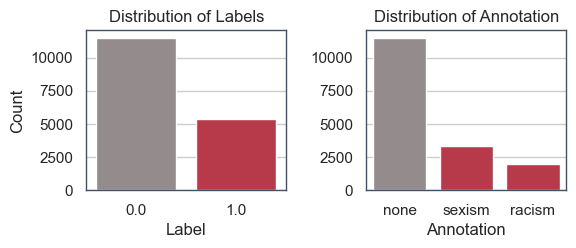

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 2))

plt.subplot(1, 2, 1)
# using the bully_pallete function to create a custom pallete
sns.countplot(x='Label', data=df, palette = bully_palette(df, 'Label', [1]))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
# adding spines using the helper function we declared earlier
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='Annotation', data=df, palette = bully_palette(df,'Annotation', [1, 2]))
plt.xlabel('Annotation')
plt.ylabel('')
plt.title('Distribution of Annotation')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
plt.show()

This is how our highlighted plots turned out. Do play around with these... highlight with your own colours... add functionalities etc.<br><br>
We can see that the lable `1` has further been divided into the categories `sexism` and `racism`. Sexism is more prevelant than racism. Racism is looked upon more harshly by the public or twitter might be efficient at removing racist tweets from their site (we never know🤷‍♀️).

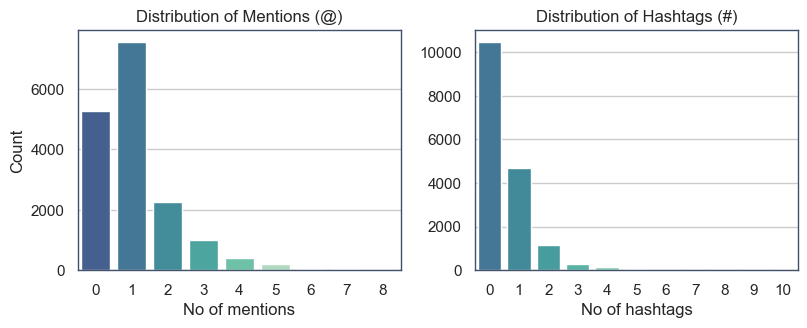

In [14]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='num_mentions', data=df, palette =  sns.color_palette("mako", n_colors=9)[3:])
plt.xlabel('No of mentions')
plt.ylabel('Count')
plt.title('Distribution of Mentions (@)')
add_spines(linewidth=1)

plt.subplot(1, 2, 2)
sns.countplot(x='num_hashtags', data=df, palette = sns.color_palette("mako", n_colors=11)[5:])
plt.xlabel('No of hashtags')
plt.ylabel('')
plt.title('Distribution of Hashtags (#)')
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.23, hspace=0.3)
plt.show()

<Figure size 600x300 with 0 Axes>

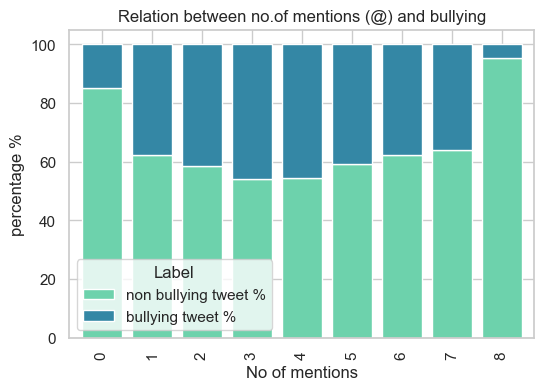

In [15]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(df['num_mentions'], df['Label'])
mention_label_cross['sum'] = mention_label_cross[0.0] + mention_label_cross[1.0]
mention_label_cross['non bullying tweet %'] = mention_label_cross[0.0]/mention_label_cross['sum']*100
mention_label_cross['bullying tweet %'] = mention_label_cross[1.0]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and bullying')
plt.show()

> Here you can see that as the mentions increase to 4, the percentage of bullying tweets increases compared to the normal ones. But the trend once again reverses as the mentions increase upto 8. No clear pattern was seen between number of hashtags and percentage of bullying tweets

### Sentiment analysis
Here I planned on checking whether the sentiment of the tweets directly correlate with bullying. ie. more  negativity a tweet contains, higher the probability of bullying. Turns out it wasn't as straightforward as that. The dataset contains a lot of negative tweets... which is a good thing since our models should be able to understand the difference between a `negative` tweet and a `bullying` tweet. It shouldn't flag every other negative tweet as bullying.

In [16]:
## Using the nltk library to analyze sentiment of each text so that we can correlate it with bullying
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'


df['Sentiment_Label'] = df['Text'].apply(get_sentiment)

df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,0,3,negative
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,0,1,negative
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,0,1,positive
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,0,1,negative
4,#mkr No No No No No No,none,0.0,1,0,negative


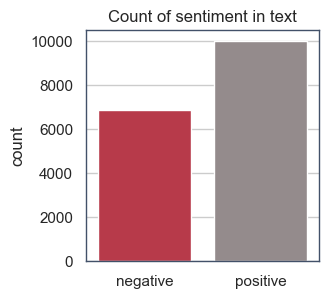

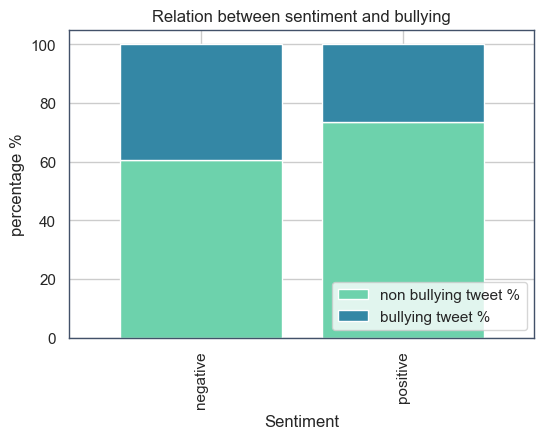

In [17]:
plt.figure(figsize=(3, 3))
df['Sentiment_Label'].value_counts()
sns.countplot(x='Sentiment_Label', data=df, palette = bully_palette(df, 'Sentiment_Label', [0]))
plt.title('Count of sentiment in text')
plt.xlabel('')
add_spines(linewidth=1)

sent_label_cross = pd.crosstab(df['Sentiment_Label'], df['Label'])
sent_label_cross['sum'] = sent_label_cross[0.0] + sent_label_cross[1.0]
sent_label_cross['non bullying tweet %'] = sent_label_cross[0.0]/sent_label_cross['sum']*100
sent_label_cross['bullying tweet %'] = sent_label_cross[1.0]/sent_label_cross['sum']*100
sent_label_cross = sent_label_cross.drop([0.0, 1.0, 'sum'], axis=1)

ax = sent_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('Sentiment')
plt.ylabel('percentage %')
plt.title('Relation between sentiment and bullying')
ax.legend(loc='lower right')
add_spines(linewidth=1)

plt.show()

<div class="alert alert-block alert-success">
<b>💡Idea:</b> We could add either the sentiment score or the label as a feature to train our models. Though I haven't actually done that... it may be a great idea for you guys to try out!!

### Analysis of common hashtags and mentions

The tweets contain a bunch of hashtags and mentions. What kind of twitter analysis would this be if we leave these out :P  Analysing this part made me have questions over the quality of the dataset. Let's understand why...
- The tweets seems to be majorly sourced from particular feeds or are retweets to particular user.
- A majority of the tweets feature the TV show `My kitchen rules`. 

#### A very key takeaway: 
The data collector was an australian interested in cooking👨‍🍳😆 

In [18]:
## Extraction of the top ten mentions and hashtags in the dataset

# Function to extract hashtags from a text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df['Hashtags'] = df['Text'].apply(extract_hashtags)

# Function to extract hashtags from a text
def extract_mentions(text):
    return re.findall(r'@\w+', text)

df['Mentions'] = df['Text'].apply(extract_mentions)

def create_counter_df(df):
    """
    Creates a dataframe that contains the Label and their count.
    Pass the dataframe containing the labels in the form of a list column as an input.
    Example usage:
    1. mentions = create_counter_df(df['Mentions'])
    2. sexist_mentions = create_counter_df(df[df.Annotation=='sexist']["Mentions"])
    """
    # Flatten the list of hashtags and count their occurrences
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)

    # Create a DataFrame from the Counter dictionary
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df
    
mentions_df = create_counter_df(df['Mentions'])
top_10_mentions = mentions_df.head(10)
sexist_mentions = create_counter_df(df[df.Annotation=='sexism']["Mentions"])
top_10_sexist_mentions = sexist_mentions.head(10)
racist_mentions = create_counter_df(df[df.Annotation=='racism']["Mentions"])
top_10_racist_mentions = racist_mentions.head(10)

hashtags_df = create_counter_df(df['Hashtags'])
top_10_hashtags = hashtags_df.head(10)
sexist_hashtags = create_counter_df(df[df.Annotation=='sexism']["Hashtags"])
top_10_sexist_hashtags = sexist_hashtags.head(10)
racist_hashtags = create_counter_df(df[df.Annotation=='racism']["Hashtags"])
top_10_racist_hashtags = racist_hashtags.head(10)

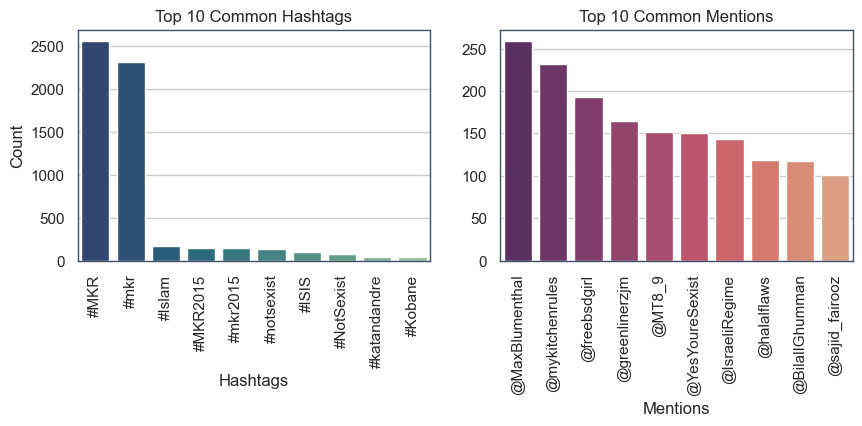

In [19]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
sns.barplot(x='Label', y='Count', data=top_10_hashtags, palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(122)
sns.barplot(x='Label', y='Count', data=top_10_mentions, palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

<img src="https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/twitter_%23%40.png"
     width="300000000" />
     
`#MKR` (@mykitchenrules) is the most popular hashtag in the dataset whereas `@MaxBlumenthal` is the most popular mention.



I did some digging around `@MaxBlumenthal` and found this:

#### Who he is:
- American author and blogger: Born in 1977, Blumenthal has written for publications like The Nation, The New York Times, and The Daily Beast. He currently edits The Grayzone website.
- Investigative journalist: Blumenthal's work focuses on politics, media, and human rights, often with a critical view of US foreign policy and the Israeli-Palestinian conflict.
- Author: He's written several books, including "Republican Gomorrah" and "Goliath: Life and Loathing in Greater Israel," which won awards and ignited debate.

#### Controversies:
- The Grayzone: Some see The Grayzone as promoting conspiracy theories and Russian propaganda, particularly regarding the Syrian Civil War. Blumenthal maintains editorial independence and focuses on investigative journalism.
- Methodology: Critics question Blumenthal's use of anonymous sources and selective evidence, while supporters defend his investigative techniques and access to information denied to mainstream media.

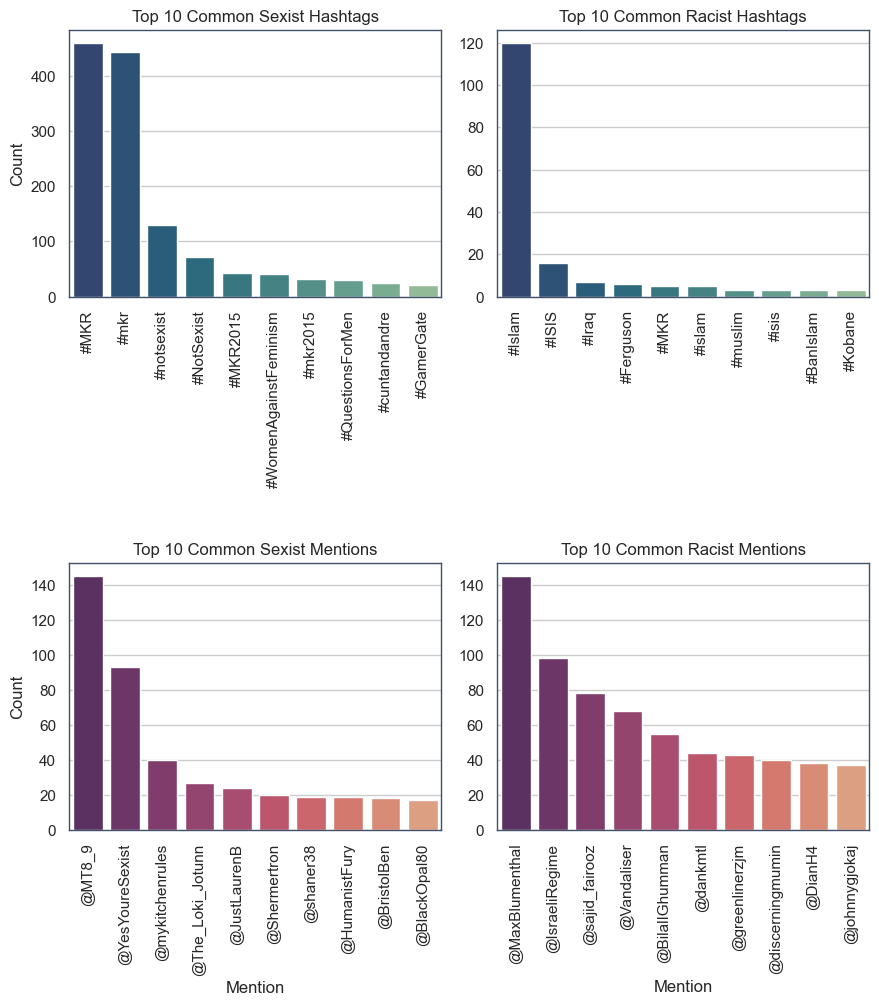

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.barplot(x='Label', y='Count', data=top_10_sexist_hashtags, palette='crest_r')
plt.title('Top 10 Common Sexist Hashtags')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(222)
sns.barplot(x='Label', y='Count', data=top_10_racist_hashtags, palette='crest_r')
plt.title('Top 10 Common Racist Hashtags')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(223)
sns.barplot(x='Label', y='Count', data=top_10_sexist_mentions, palette='flare_r')
plt.title('Top 10 Common Sexist Mentions')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplot(224)
sns.barplot(x='Label', y='Count', data=top_10_racist_mentions, palette='flare_r')
plt.title('Top 10 Common Racist Mentions')
plt.xlabel('Mention')
plt.ylabel('')
plt.xticks(rotation=90)
add_spines(linewidth=1)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=1)
plt.show()

#### Key takeaways from the most common @ and #s

- For some reason `#MKR` and `#mkr` (my kitchen rules) feature on the top of the sexist hashtags. Maybe coz its a cooking show. lol. It might be due to the fact that #MKR is the most common hashtag on the dataset. <br>
- You can see religiously motived terrorist groups like `#isis` feature on the most common racist hashtags <br>
- `@YesYoureSexist` sounds like a provocative username. No wonder it has the second most sexist mentions 
- `@MaxBlumenthal` a controversial American author and blogger features on the top of Racist mentions

### Preprocessing the text 

In [21]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tweet_tokens = nltk.word_tokenize(tweet)
#     tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])
    
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

In [18]:
df['Text'] = df['Text'].apply(clean_tweet)
df.head()

,Text,Annotation,Label,num_hashtags,num_mentions,Sentiment_Label,Hashtags,Mentions
0,I read they in contextno change in mean th...,none,0.0,0,3,negative,[],"[@halalflaws, @biebervalue, @greenlinerzjm]"
1,now you idiot claim that people who try to s...,none,0.0,0,1,negative,[],[@ShreyaBafna3]
2,call I sexist but when I go to an auto plac...,sexism,1.0,0,1,positive,[],[@Mooseoftorment]
3,wrong isis follow the example of mohammed an...,racism,1.0,0,1,negative,[],[@g0ssipsquirrelx]
4,no no no no no no,none,0.0,1,0,negative,[#mkr],[]


In [22]:
print('_________Sample clean tweets_________')
simple_tweet = df[df['Label'] == 0]['Text'].iloc[1]
print('\n\nSimple tweet: ', simple_tweet)
sexist_tweet = df[df['Annotation'] == 'sexism']['Text'].iloc[0]
print('\n\nSexist tweet: ', sexist_tweet)
racist_tweet = df[df['Annotation'] == 'racism']['Text'].iloc[0]
print('\n\nRacist tweet: ', racist_tweet)
print('\n\n_______________________________')

_________Sample clean tweets_________


Simple tweet:  @ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.


Sexist tweet:  RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy


Racist tweet:  @g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.


_______________________________


### ☁️ Wordclouds for toxic text <a class="anchor"  id="section_1_3"></a>

We are using a popular method of plotting wordclouds in the shapes of masks created out of png images. Lets say you want to create a wordcloud for text related to sexism...
1. Simply google search for an image like 'sexism logo png'
2. Choose an image of your choice, left click on it and open it in a new tab <br>
3. Copy the url and paste it in the code hidden below

For a detailed look at how to do this.. check out this notebook: [Spooky NLP and Topic Modelling tutorial](https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial/notebook) <br>
This notebook uses the Base64 encoding of images to create the wordclouds while you can straightaway use the URL of the images as I have done below
Viola!! there you have it. Beautiful wordclouds with meanings represented in the form of shapes. The hidden code cell below explains all the steps.

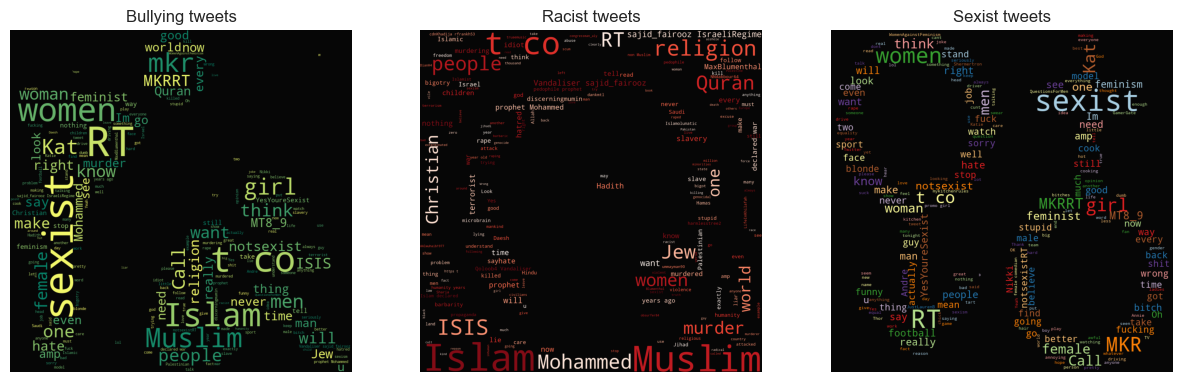

In [24]:
stopword=set(STOPWORDS)
plt.figure(figsize=(15,40))

## Common words in all bullying tweets-----------------------------------------------------------------------------------
plt.subplot(131)
# 1. Get text
bully_text = df[df.Label==1.0]["Text"].values
Text = ''
for text in bully_text:
    Text += text

# 2. Load png image from url and create mask
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/bullying-computer-icons-harassment-clip-art-bully.jpg'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

# 3. Plot wordcloud
wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Bullying tweets')
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)


## Common words in all racist tweets-----------------------------------------------------------------------------------
# Repeat for other plots
plt.subplot(132)
bully_text = df[df.Annotation=='racism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://clipart-library.com/img1/1475559.png'
response = requests.get(image_url, stream=True)
response.raise_for_status()
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.title('Racist tweets')
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)


## Common words in all sexist tweets-----------------------------------------------------------------------------------
plt.subplot(133)
bully_text = df[df.Annotation=='sexism']["Text"].values
Text = ''
for text in bully_text:
    Text += text
    
image_url = 'https://raw.githubusercontent.com/harshjadhav890/cyberbullying_detection/main/woman-gender-symbol-male-female-text-line-circle-number-png-clipart.jpg'
response.raise_for_status()
response = requests.get(image_url, stream=True)
mask = np.array(Image.open(response.raw))

wc = WordCloud(background_color = 'black', mask = mask, contour_width = 2,
     contour_color = 'black', colormap = 'BuPu_r', width = 800, height = 800, stopwords = stopword).generate(Text)
plt.axis("off")
plt.title('Sexist tweets')
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

# 👾 Modelling <a class="anchor"  id="chapter2"></a>

### Preprocessing for modelling
Most of these steps have been covered earlier. You may expand this section to view the rest of the changes I made to the dataset

In [26]:
# ignore this. I did this for ease of processing when i restart the kernel
# this part gives you the completely preprocessed data right to the point where you just need to oversample and split it

df = pd.read_csv("twitter_parsed_dataset.csv")
df = df.drop(['id', 'index'], axis=1)
df.rename(columns={'oh_label': 'Label'}, inplace=True)
df = df.dropna(subset=['Label'])

# Adding hashtags and mentions_____________________________________________________________________________________# 
# here we create a function to count the number of hashtags and mentions and then create two columns to store this data
def count_symbols(text):
#     hashtag_count = len(re.findall(r'#', text))
    mention_count = len(re.findall(r'@', text))
#     return hashtag_count, mention_count
    return mention_count

# Apply the function to each row in the 'text' column
df[['num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))
# df[['num_hashtags', 'num_mentions']] = df['Text'].apply(lambda x: pd.Series(count_symbols(x)))


# Analyze sentiment of each text____________________________________________________________________________________# 
sia = SentimentIntensityAnalyzer()

# Function to get sentiment of a text
def get_sentiment(text):
    compound_score = sia.polarity_scores(text)['compound']
    return 'positive' if compound_score >= 0 else 'negative'

# Apply the function to each row in the 'Text' column
df['Sentiment_Label'] = df['Text'].apply(get_sentiment)


# Cleaning the tweets_________________________________________________________________________________________________# 
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions and hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)
    
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    # Remove 'RT' (Retweet) indicator
    tweet = re.sub(r'\bRT\b', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
      
    # Lemmatization
    doc = nlp(tweet)
    # Lemmatize each token and join them back into a string
    tweet = ' '.join([token.lemma_ for token in doc])
    
    return tweet

df['Text'] = df['Text'].apply(clean_tweet)
#____________________________________________________________________________________________________________________# 

# One hot encoding of the sentiment category
one_hot_encoded = pd.get_dummies(df['Sentiment_Label'], prefix='sentiment')
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop('Sentiment_Label', axis=1)
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['Text'] = df['Text'].str.strip()

# Step 2: Upsample the data using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

In [27]:
# Step 2: Oversample the data using RandomOverSampler to reduce imbalance between Labels (Bullying and non bullying)
ros = RandomOverSampler(random_state=42)
X = df['Text'].values.reshape(-1, 1)
y = df['Label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)

# convert text (object) data to string for w2v
X_resampled= [str(obj) for obj in X_resampled]
X_resampled = np.array(X_resampled)

## ML approach with word2vec <a class="anchor"  id="section_2_1"></a>
#### Why use Word2Vec?
- Semantic understanding: Word2Vec captures the semantic relationships between words, which is crucial for understanding the nuances of language used in bullying. It can differentiate between words with similar spellings but different meanings (e.g., "joke" vs. "mock") and identify synonyms and antonyms, helping to detect subtle insults and sarcasm often employed in cyberbullying.

- Handling slang and abbreviations: Twitter language is full of slang, abbreviations, and emojis. Word2Vec can learn these informal and often-evolving expressions, leading to more accurate detection of bullying even when it doesn't use traditional language patterns.


#### Limitations of using Word2Vec
- Bias: Word2Vec models can inherit biases from the training data, potentially leading to discriminatory outcomes. Careful selection of training data and evaluation methods are crucial.
- Context sensitivity: Subtle forms of bullying often rely on context not captured solely by word meaning. Combining Word2Vec with other approaches that consider context can improve accuracy.

For detailed explaination of the intuition behind W2V read: [Word2Vec Explained](https://archive.is/4lJS5)

In [5]:
# Train Word2Vec Model
sentences = [word_tokenize(text) for text in X_resampled]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # Adjust parameters as needed

# Convert Text to Embeddings
def get_embedding(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
    if len(tokens) > 0:
        # Return the average of word embeddings for the tokens
        return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
    else:
        return None

# Create an array of embeddings for each text
X_resampled = [get_embedding(text) for text in X_resampled]

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 5: Model Training (Using a RandomForestClassifier as an example)
X_train = np.array(X_train)
X_test = np.array(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.8867637470115193
F1 Score: 0.8832623795653148


In [36]:
import joblib
joblib.dump(model,'model.sav')

['model.sav']

In [35]:
len(X_train)

18401